In [8]:
import pandas as pd
import numpy as np
import os
from utils import *
import cvxpy as cp
from datetime import timedelta
from matplotlib import pyplot as plt

def get_index_price(index:str, start_date:str, end_date:str, field:str='close'):
    index_list = ['000300.SH', '000905.SH', '000852.SH', '000985.SH']
    if index not in index_list:
        print(f'pleace select from {index_list}')
    
 
    return index.pivot(index='trade_date', columns='ts_code', values=field)

def port_opt(period_list, industry_list, barra_list, past_weight, stock_today, index_today, barra_limit, turnover=0.20):
    # 定义要优化的变量，设置非负约束
    weights = cp.Variable(shape=(len(stock_today), 1), nonneg=True)

    # 收集约束条件
    constraints = []

    # 1. 权重之和等于1
    constraints.append(cp.sum(weights) == 1)

    # 2. 个股权重限制为1%
    constraints.append(weights <= 0.01)

    # 3. 行业权重限制与指数的差异限制为5%
    constraints.append(weights[:, 0] @ stock_today[industry_list] - index_today[industry_list] <= 0.05)
    constraints.append(weights[:, 0] @ stock_today[industry_list] - index_today[industry_list] >= -0.05)

    # 4. barra 偏离限制
    for _barra in barra_list:
        constraints.append(weights[:, 0] @ stock_today[_barra] - index_today[_barra] <= barra_limit)
        constraints.append(weights[:, 0] @ stock_today[_barra] - index_today[_barra] >= -barra_limit)

    # 5. 限制换手率（权重变化的总和）为15%
    trade_cost_sum = cp.sum(cp.abs(weights - past_weight[['past_weight']].iloc[:len(stock_today)]))

    if past_weight['past_weight'].sum() > 0.5:  # 首日排除
        constraints.append(trade_cost_sum <= turnover)  # 单日换手不超过15%

    # 定义目标函数
    profit_sum = cp.sum(cp.multiply(weights, stock_today[period_list])) 
    obj = profit_sum 

    # 传递问题给求解器
    problem = cp.Problem(cp.Maximize(obj), constraints)

    try:
        problem.solve(solver='ECOS', qcp=True, max_iters=2000)
    except:
        problem.solve()

    weights_value = weights.value
    if weights_value is None:
        return past_weight.set_index('Symbol')['past_weight'].to_dict(), problem.status
    weights_value = pd.concat([stock_today[['Symbol']].reset_index(drop=True),
                                pd.DataFrame(weights_value[:, 0], columns=['weight']).reset_index(drop=True)],
                                axis=1)
    weights_value.loc[weights_value['weight'] < 0.00001, 'weight'] = 0
    weights_value = weights_value[weights_value['weight'] != 0]
    weights_value['weight'] = weights_value['weight'] / weights_value['weight'].sum()
    weights_value = pd.merge(left=weights_value, right=past_weight[['Symbol']], on='Symbol', how='outer')
    weights_value.fillna(0, inplace=True)
    weights_value = weights_value.set_index('Symbol')['weight'].to_dict()
    return weights_value, problem.status

def trade_cal(past_weight, holding_df, trade_target, today_stock_return, non_trade, sell_trade_cost = 0.0, buy_trade_cost = 0.0, drop_list=[]):

    weight_diff = pd.merge(left=past_weight, right=trade_target, on='Symbol', how='outer')
    weight_diff.fillna(0, inplace=True)
    weight_diff = weight_diff[(weight_diff['past_weight'] != 0) | (weight_diff['trade_weight'] != 0)]  # 有交易的trade_target
    weight_diff = pd.merge(weight_diff, today_stock_return, on=['Symbol'], how='left')
    weight_diff['diff'] = weight_diff['trade_weight'] - weight_diff['past_weight']
    weight_diff.loc[abs(weight_diff['diff']) < 0.001, 'diff'] = 0  # 差距过小的不进行交易
    weight_diff.loc[weight_diff['trade_weight'] == 0, 'diff'] = \
        -weight_diff.loc[weight_diff['trade_weight'] == 0, 'past_weight']


    sell_list = list(weight_diff.loc[np.where((weight_diff['diff'] < 0)
                                                & (weight_diff['vwap_next'] != 0)), 'Symbol'])
    buy_list = list(weight_diff.loc[np.where((weight_diff['diff'] > 0)
                                                & (weight_diff['vwap_next'] != 0)), 'Symbol'])
    stable_list = [stock_ for stock_ in holding_df.index if stock_ not in sell_list + buy_list]
    stable_list.remove('cash')

    if non_trade!=0:
        sell_list = []
        buy_list = []
        stable_list= [stock_ for stock_ in holding_df.index]
        stable_list.remove('cash')

    past_value = holding_df['past_value'].sum()  # 前一天持有的所有资产，因为要提前做交易单，所以按前一天净值算
    # 未停牌的能卖出的按开盘价结算卖出
    total_sell = 0


    for stock_ in sell_list:
        stock_info = weight_diff[weight_diff['Symbol'] == stock_]
        next_holding = holding_df.loc[stock_, 'past_value'] / stock_info['vwap'].iloc[0] \
                        * stock_info['vwap_next'].iloc[0]  # 转日开盘后个股价值
        holding_df.loc['cash', 'past_value'] += -next_holding * stock_info['diff'].iloc[0] \
                                                / stock_info['past_weight'].iloc[0] \
                                                * (1 - sell_trade_cost)  # 卖出部分变现
        holding_df.loc[stock_, 'past_value'] = next_holding * stock_info['trade_weight'].iloc[0] \
                                                / stock_info['past_weight'].iloc[0]  # 持仓改变
        total_sell += -next_holding * stock_info['diff'].iloc[0] \
                                                / stock_info['past_weight'].iloc[0] * (1 - sell_trade_cost)
    for stock_ in drop_list:  # 直接被收购退市的，按价值卖出
        holding_df.loc['cash', 'past_value'] += holding_df.loc[stock_, 'past_value'] * (1 - sell_trade_cost)
        holding_df.loc[stock_, 'past_value'] = 0
        total_sell += holding_df.loc[stock_, 'past_value'] * (1 - sell_trade_cost)

    # 剩余的钱且未停牌的按weight重置进行买入
    buy_df = weight_diff[weight_diff['Symbol'].isin(buy_list)]['diff'].sum()
    buy_cash = holding_df.loc['cash'].iloc[0]  # 可以买的钱

    total_buy = 0
    for stock_ in buy_list:
        stock_info = weight_diff[weight_diff['Symbol'] == stock_]
        buy_asset_total = past_value * stock_info['diff'].iloc[0]  # 按总资产计算的购买数量
        buy_asset_cash = buy_cash * stock_info['diff'].iloc[0] / buy_df  # 按现有资金计算的购买量
        buy_asset = min(buy_asset_cash, buy_asset_total)
        holding_df.loc['cash', 'past_value'] -= buy_asset
        if stock_info['past_weight'].iloc[0] == 0:  # 昨日没持仓
            holding_df.loc[stock_, 'past_value'] = buy_asset * (1 - buy_trade_cost)
        else:  # 昨天有持仓
            holding_df.loc[stock_, 'past_value'] = holding_df.loc[stock_, 'past_value'] \
                                                    / stock_info['vwap'].iloc[0] \
                                                    * stock_info['vwap_next'].iloc[0] \
                                                    + buy_asset * (1 - buy_trade_cost)
        total_buy += buy_asset

    # 无操作个股按收盘、开盘结算
    for stock_ in stable_list:
        stock_info = weight_diff[weight_diff['Symbol'] == stock_]
        holding_df.loc[stock_, 'past_value'] = holding_df.loc[stock_, 'past_value'] \
                                                / stock_info['vwap'].iloc[0] \
                                                * stock_info['vwap_next'].iloc[0]  # 转日开盘后个股价值


    # 更新持仓，去除0的
    holding_df = holding_df[holding_df['past_value'] != 0]
    if 'cash' not in holding_df.index:
        holding_df.loc['cash'] = 0
    # holding_df.dropna(inplace=True)

    # 尾盘结算价格
    holding_df.reset_index(inplace=True)

    holding_df.set_index('Symbol', inplace=True)
    turnover_rate = (total_buy + total_sell) / past_value / 2

    return holding_df, turnover_rate

In [9]:

startdate = '2021-01-01'
enddate = '2023-12-31'
chosen_index = '000300.SH'
barra_limit = 0.3

index_data_dict = {
    '000905.SH': 'idx__csi500_weight.parquet',
    '000300.SH': 'idx__csi300_weight.parquet',
    '000852.SH': 'idx__csi1000_weight.parquet',
}

In [ ]:
# get prediction
score_df = pd.read_parquet('pred1.parquet')
score_df.reset_index(inplace=True)
score_df['Date'] = pd.to_datetime(score_df['Date'])
score_df.columns = ['Date', 'Symbol', 'pred']


<Axes: xlabel='Date'>

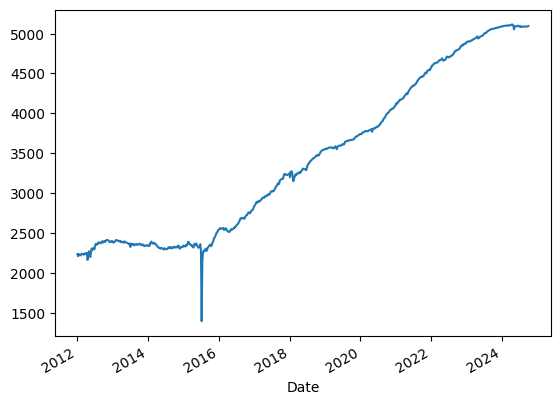

In [23]:
# how many unique pred in each date
score_df.groupby('Date')['pred'].nunique().plot()

In [ ]:


# get return data
return_df = get_price([],startdate, enddate)
return_df = return_df.stack().reset_index().rename(columns={0:'vwap'})
return_df['vwap_next'] = return_df.groupby('Symbol')['vwap'].shift(-1)
# if vwap_next is nan, fill with vwap
return_df['vwap_next'].fillna(return_df['vwap'], inplace=True)
return_df['Date'] = pd.to_datetime(return_df['Date'])

# get barra and industrial data
barra_df = pd.read_parquet(os.path.join(fc.BARR_DIR, 'BarraFactorTable.parquet'))
barra_df['Date'] = pd.to_datetime(barra_df['Date'])


# merge barra data to return
return_df = pd.merge(return_df, barra_df, on=['Date', 'Symbol'], how='left')

# merge barra, industrial and return data to score
score_df = pd.merge(score_df, return_df, on=['Date', 'Symbol'], how='left')
score_df.dropna(inplace=True)

index_data_dict = {
    '000905.SH': 'idx__csi500_weight.parquet',
    '000300.SH': 'idx__csi300_weight.parquet',
    '000852.SH': 'idx__csi1000_weight.parquet',
}

# get index weight
index_weight = pd.read_parquet(os.path.join(fc.BARR_DIR, index_data_dict[chosen_index]))
index_weight = index_weight[['Date','Symbol', 'Weight']]
index_weight['Date'] = pd.to_datetime(index_weight['Date'])
index_weight = pd.merge(index_weight, return_df, on=['Date', 'Symbol'], how='left')
index_weight.dropna(inplace=True)

# get index return
index_return = pd.read_csv(f'{chosen_index}.csv')[['ts_code', 'trade_date', 'close']]
index_return['trade_date'] = pd.to_datetime(index_return['trade_date'], format='%Y%m%d')
index_return = index_return.loc[(index_return.trade_date >= startdate) & (index_return.trade_date <= enddate), ['ts_code','trade_date', 'close']]
index_return.columns = ['index', 'Date', 'index_close']

# define barra and industry list
barra_list = ['Beta', 'Momentum', 'Size', 'EarningsYield', 'ResidualVolatility', 'Growth',
    'BooktoPrice', 'Leverage', 'Liquidity', 'NonlinearSize']

barra_std_list = [barra_ + '_std' for barra_ in barra_list]

industry_list = ['Bank',
    'RealEstate', 'Pharmaceutical', 'CateringTourism',
    'CommercialRetailing', 'Mechanical', 'ConstructionMaterials',
    'HouseholdAppliances', 'TextileApparel', 'FoodBeverage',
    'ElectronicComponents', 'Automobile', 'LightManufacturing',
    'PowerUtilities', 'Comprehensive', 'Communications', 'Others',
    'PetroleumPetrochemical', 'NonferrousMetals', 'AgricultureFarming',
    'Architecture', 'Computers', 'Transport', 'BasicChemicals', 'Coal',
    'ElectricalEquipment', 'DefenseMilitary', 'NonBankFinance', 'Steel',
    'Media']

# get index barra and industry
df_index = pd.DataFrame(columns=barra_list + industry_list + barra_std_list)
for _date, _df in index_weight.groupby('Date'):
    # average index barra
    df_index.loc[_date, barra_list] = np.average(_df[barra_list], weights=_df['Weight'], axis=0)
#     # average index barra std
#     df_index.loc[_date, barra_std_list] = np.average(
#             (_df[barra_list] - df_index.loc[_date, barra_list]) ** 2, weights=_df['Weight'],
#             axis=0) ** 0.5
    # industry weight in index
    df_index.loc[_date, industry_list] = np.average(_df[industry_list], weights=_df['Weight'], axis=0)

# calculate barra limit
for _barra in barra_list:
    df_index[_barra + '_lower'] = df_index[_barra] - barra_limit
    df_index[_barra + '_upper'] = df_index[_barra] + barra_limit

# only consider stocks in index
score_df = pd.merge(score_df, index_weight[['Date', 'Symbol', 'Weight']], on=['Date', 'Symbol'], how = 'left')
score_df = score_df[score_df['Weight'].notna()]

date_list = score_df['Date'].drop_duplicates().sort_values().to_list()
opt_weight = {}  # 字典形式储存结果
initial_asset = 1000
asset_record = pd.DataFrame(columns=['asset'])  # 纪录每日净值
holding_record = {}  # 持仓权重，尾盘更新
holding_record[date_list[0]] = pd.DataFrame({'Symbol':['cash'],
                                                'past_value':[initial_asset]}).set_index('Symbol')